#LSTM MODEL 

In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

In [ ]:
data = pd.read_csv("full_data.csv")

In [ ]:
MAX_NB_WORDS = 10000 
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 50

##Tokenizer, sequences, padding

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(data['ingredients'].values)
word_index = tokenizer.word_index

In [ ]:
X = tokenizer.texts_to_sequences(data['ingredients'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of X:', X.shape)

Shape of X: (39752, 250)


In [ ]:
Y = pd.get_dummies(data['cuisine']).values
print('Shape of Y:', Y.shape)

Shape of Y: (39752, 20)


##Data splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 1)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(35776, 250) (35776, 20)
(3976, 250) (3976, 20)


##Training the model

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(100, dropout=0.1, recurrent_dropout=0.1)))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=1/9,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]) 

Epoch 1/5
497/497 [==============================] - 714s 1s/step - loss: 2.1548 - accuracy: 0.3584 - val_loss: 1.2386 - val_accuracy: 0.6192
Epoch 2/5
497/497 [==============================] - 676s 1s/step - loss: 1.1682 - accuracy: 0.6446 - val_loss: 1.0244 - val_accuracy: 0.6876
Epoch 3/5
497/497 [==============================] - 675s 1s/step - loss: 0.9677 - accuracy: 0.6992 - val_loss: 0.9401 - val_accuracy: 0.7165
Epoch 4/5
497/497 [==============================] - 677s 1s/step - loss: 0.8461 - accuracy: 0.7397 - val_loss: 0.8904 - val_accuracy: 0.7274
Epoch 5/5
497/497 [==============================] - 684s 1s/step - loss: 0.8000 - accuracy: 0.7519 - val_loss: 0.8675 - val_accuracy: 0.7445


##Evaluation

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

125/125 [==============================] - 14s 110ms/step - loss: 0.8242 - accuracy: 0.7520
Test set
  Loss: 0.824
  Accuracy: 0.752


In [ ]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.28      0.42        53
           1       0.38      0.40      0.39        87
           2       0.72      0.67      0.69       138
           3       0.77      0.88      0.82       281
           4       0.54      0.43      0.48        74
           5       0.54      0.57      0.55       245
           6       0.73      0.71      0.72       124
           7       0.82      0.92      0.87       295
           8       1.00      0.04      0.08        68
           9       0.80      0.90      0.84       816
          10       0.76      0.59      0.67        54
          11       0.71      0.80      0.75       138
          12       0.84      0.55      0.67        76
          13       0.91      0.89      0.90       635
          14       0.80      0.67      0.73        94
          15       0.34      0.38      0.36        39
          16       0.74      0.80      0.77       435
          17       0.48    

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1))

0.7520120724346077

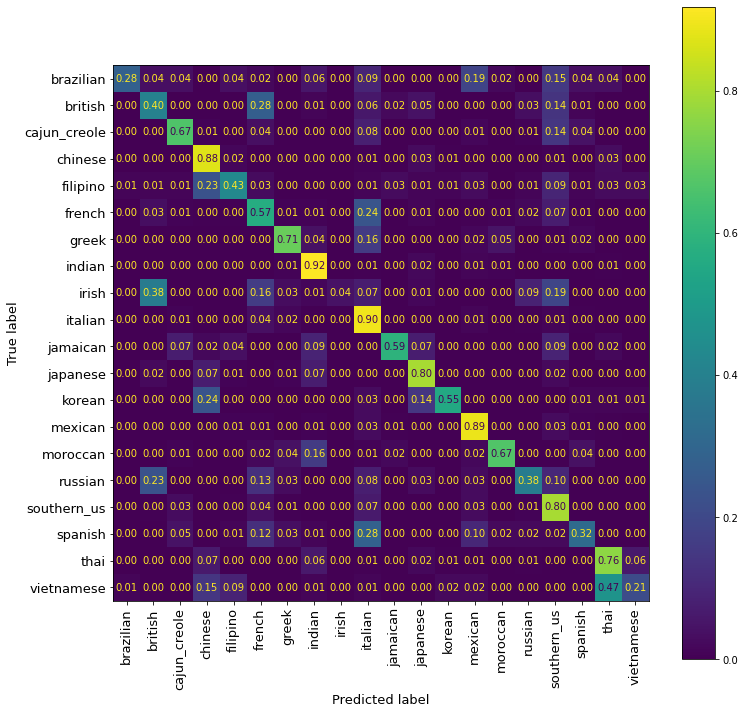

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = np.unique(data['cuisine'])
y_test_labels = [labels[index] for index in np.argmax(Y_test, axis=1)]
y_prediction_labels = [labels[index] for index in np.argmax(predictions, axis=1)]

conf_mat = confusion_matrix(y_test_labels, y_prediction_labels, labels, normalize = "true")
cmd = ConfusionMatrixDisplay(conf_mat, display_labels=labels)
fig, ax = plt.subplots(figsize=(12,12))
cmd.plot(ax=ax,values_format = '.2f')
ax.tick_params(axis='x', rotation=90)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(13)
fig.savefig('LSTMconf_mat.png')